# How to merge our time series?

## Time between consecutive data points

So far we have 3 data sources:
* **Cbtool data** (`VM_runtime_app_*.csv`)
* **CPU+Memory** (`metric_node_baati_cpu.csv`, `metric_node_baati_memory.csv`)
* **OS metrics** (`metric_os.csv`)

We need to check what are the time differences between consecutive data points to be able to merge those sources reasonably.

We'll use data from `linpack_12x20` experiment.

In [1]:
from collections import defaultdict

import pandas as pd

from helpers.load_data import (
    get_cbtool_data,
    get_cpu_data,
    get_experiments_paths,
    get_mem_data,
    get_os_metrics,
)


def count_time_diffs(df: pd.DataFrame):
    res = defaultdict(int)

    for i in range(1, len(df)):
        diff = df['time'].iloc[i] - df['time'].iloc[i - 1]
        res[diff] += 1

    return res


def print_time_diffs(diff_count: dict):
    print('Differences between consecutive data points:')
    
    diff_sum = 0
    number = 0
    
    for diff, count in sorted(diff_count.items()):
        print(f'{diff} seconds: {count} times')
        diff_sum += diff * count
        number += count
    
    print(f'Average time diff: {diff_sum / number:.4f}')
        

experiments_path = '../../data'
experiment_name = 'linpack_12x20'
path = next(get_experiments_paths(experiment_name, experiments_path))

### Cbtool data

In [2]:
df_cbt = get_cbtool_data(path, instances_n=12)
diff_count = count_time_diffs(df_cbt)
print_time_diffs(diff_count)

Differences between consecutive data points:
51 seconds: 2 times
52 seconds: 18 times
53 seconds: 10 times
54 seconds: 11 times
55 seconds: 6 times
56 seconds: 7 times
57 seconds: 7 times
59 seconds: 1 times
60 seconds: 1 times
64 seconds: 1 times
67 seconds: 1 times
68 seconds: 1 times
70 seconds: 1 times
71 seconds: 3 times
72 seconds: 1 times
73 seconds: 2 times
74 seconds: 1 times
75 seconds: 1 times
76 seconds: 1 times
79 seconds: 1 times
80 seconds: 1 times
81 seconds: 1 times
82 seconds: 1 times
84 seconds: 2 times
85 seconds: 1 times
86 seconds: 1 times
87 seconds: 1 times
88 seconds: 1 times
89 seconds: 3 times
90 seconds: 1 times
99 seconds: 2 times
101 seconds: 2 times
102 seconds: 3 times
103 seconds: 3 times
104 seconds: 1 times
108 seconds: 1 times
112 seconds: 1 times
116 seconds: 1 times
119 seconds: 1 times
120 seconds: 1 times
121 seconds: 2 times
124 seconds: 1 times
126 seconds: 2 times
128 seconds: 1 times
131 seconds: 1 times
137 seconds: 1 times
138 seconds: 1 ti

The tests are run sequentially. We can see that initially, when there is only one instance on the machine, the completion time is around `52` seconds.  When more instances are added, the completion time lengthens to even `238` seconds.

### CPU / Memory

In [3]:
df_cpu = get_cpu_data(path)
diff_count = count_time_diffs(df_cpu)
print_time_diffs(diff_count)

Differences between consecutive data points:
10 seconds: 454 times
11 seconds: 73 times
12 seconds: 1 times
20 seconds: 304 times
21 seconds: 177 times
22 seconds: 1 times
30 seconds: 8 times
31 seconds: 6 times
33 seconds: 1 times
Average time diff: 15.2517


From the field `windowSeconds` we know that each CPU/memory value is averaged from the last `30` seconds.

We can see that these metrics gathered mostly every `10` or `20` seconds.

### OS metrics

In [4]:
df_os = get_os_metrics(path)
diff_count = count_time_diffs(df_os)
print_time_diffs(diff_count)

Differences between consecutive data points:
5 seconds: 2221 times
6 seconds: 747 times
7 seconds: 6 times
8 seconds: 1 times
Average time diff: 5.2561


On the other hand, OS metrics are gathered more regularly - the frequency is `~5s` with some small delays.

## Emerging problems

#### **1. Our dataseries have different frequencies and semantics.**
* Cbtool `app_latency` and `app_throughput` is an average from a single workload. The completion time of the workload varies with time (depends on the performance of the machine).

* CPU/memory metrics are averages from last `30s` and have alternating frequency (lower than `30s`).

* OS metrics are measurements in a given time, but the semantic depends on the metrics class. More info at: https://github.com/prometheus/node_exporter#enabled-by-default

#### **2. New instance can be running for a while without any trace in cbtool metrics.**
Imagine a situation, in which completion time of the workload is initially 50s. One instance is running and then we add a second instance at time `T`. If we take first metric of the second instance (time `T+50`) as a point dividing `instances_n=1` and `instances_n=2`, then we have 50 seconds of two instances running while `instances_n=1`, so we need to take that into account.

## Solution

### How to merge Cbtool metrics with CPU/memory metrics?

Cbtool metrics are the rarest, so for every Cbtool metric, we want to select and average CPU metrics that correspond CPU load during running the workload run. We have cbtool windows (50-300s) and CPU windows (30s) every 10/20s that overlap, so multiple CPU windows can fit into one Cbtool window.

If we average overlapping windows, it will work like a weighted average.

If we select only one CPU window within Cbtool window, then it will only represent a part of the experiment.

Another idea is to take as many non-overlapping CPU windows as we can and average them.

### How to merge Cbtool metrics with OS metrics?

We just take all OS metrics fitting into Cbtool window and average them.

## Implementation

Let's see how new implementation compares to the old one.

In [5]:
from helpers.load_data import (
    get_data_with_metrics,
    get_data_with_metrics_old,
    trim_experiment,
)
from helpers.regression import (
    draw_regression_graph,
    fit_regression,
)


experiments_path = '../../data'
experiment_name = 'linpack_12x20'
path = next(get_experiments_paths(experiment_name, experiments_path))
df1 = get_data_with_metrics_old(path, instances_n=12, max_time_diff=5)
df1 = trim_experiment(df1, 6)
df2 = get_data_with_metrics(path, instances_n=12, cpu_window=30)
df2 = trim_experiment(df2, 6)

### Old - `cpu ~ instances_n`

                            OLS Regression Results                            
Dep. Variable:                    cpu   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     3954.
Date:                Thu, 05 Nov 2020   Prob (F-statistic):           1.22e-66
Time:                        22:16:08   Log-Likelihood:                -576.74
No. Observations:                  77   AIC:                             1157.
Df Residuals:                      75   BIC:                             1162.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     450.1931    106.285      4.236      

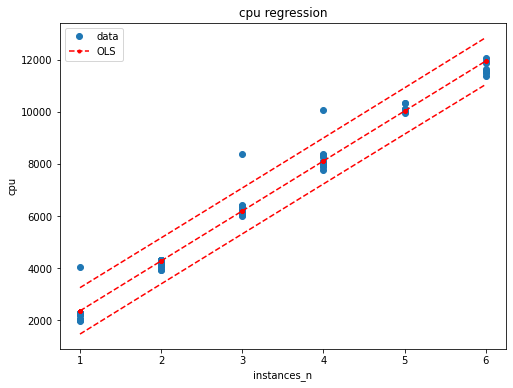

In [6]:
results = fit_regression(data=df1, formula='cpu ~ instances_n')
draw_regression_graph(results, df1, metric_name='cpu', variable='instances_n')
print(results.summary())

### New - `cpu ~ instances_n`

                            OLS Regression Results                            
Dep. Variable:                    cpu   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 3.020e+04
Date:                Thu, 05 Nov 2020   Prob (F-statistic):          5.27e-131
Time:                        22:16:09   Log-Likelihood:                -711.03
No. Observations:                 107   AIC:                             1426.
Df Residuals:                     105   BIC:                             1431.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     375.4075     38.702      9.700      

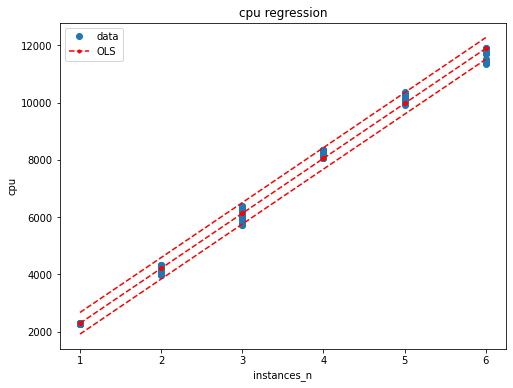

In [7]:
results = fit_regression(data=df2, formula='cpu ~ instances_n')
draw_regression_graph(results, df2, metric_name='cpu', variable='instances_n')
print(results.summary())

### Old - `app_throughput ~ instances_n`

                            OLS Regression Results                            
Dep. Variable:         app_throughput   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     716.0
Date:                Thu, 05 Nov 2020   Prob (F-statistic):           4.14e-40
Time:                        22:16:09   Log-Likelihood:                -164.70
No. Observations:                  77   AIC:                             333.4
Df Residuals:                      75   BIC:                             338.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      40.4969      0.504     80.343      

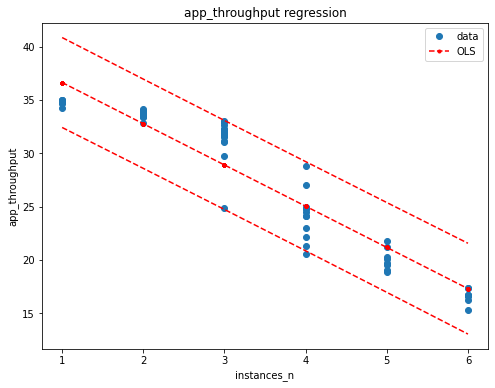

In [8]:
results = fit_regression(data=df1, formula='app_throughput ~ instances_n')
draw_regression_graph(results, df1, metric_name='app_throughput', variable='instances_n')
print(results.summary())

### New - `app_throughput ~ instances_n`

                            OLS Regression Results                            
Dep. Variable:         app_throughput   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     1101.
Date:                Thu, 05 Nov 2020   Prob (F-statistic):           1.82e-57
Time:                        22:16:10   Log-Likelihood:                -222.96
No. Observations:                 107   AIC:                             449.9
Df Residuals:                     105   BIC:                             455.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      40.5650      0.404    100.317      

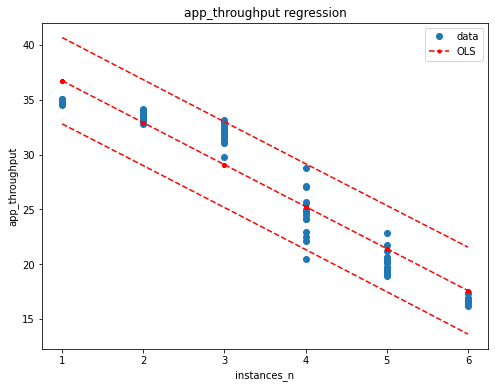

In [9]:
results = fit_regression(data=df2, formula='app_throughput ~ instances_n')
draw_regression_graph(results, df2, metric_name='app_throughput', variable='instances_n')
print(results.summary())

### Old - `app_throughput ~ cpu`

                            OLS Regression Results                            
Dep. Variable:         app_throughput   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     692.5
Date:                Thu, 05 Nov 2020   Prob (F-statistic):           1.28e-39
Time:                        22:16:10   Log-Likelihood:                -165.86
No. Observations:                  77   AIC:                             335.7
Df Residuals:                      75   BIC:                             340.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     41.2653      0.538     76.660      0.0

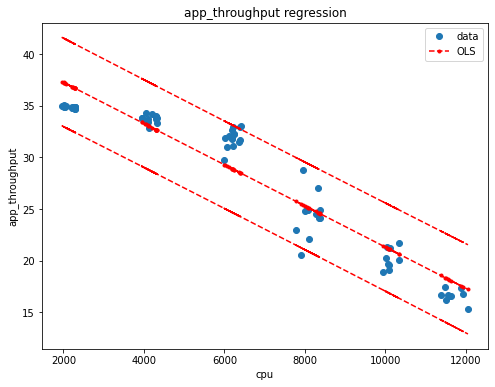

In [10]:
results = fit_regression(data=df1, formula='app_throughput ~ cpu')
draw_regression_graph(results, df1, metric_name='app_throughput', variable='cpu')
print(results.summary())

### New - `app_throughput ~ cpu`

                            OLS Regression Results                            
Dep. Variable:         app_throughput   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     1098.
Date:                Thu, 05 Nov 2020   Prob (F-statistic):           2.01e-57
Time:                        22:16:11   Log-Likelihood:                -223.06
No. Observations:                 107   AIC:                             450.1
Df Residuals:                     105   BIC:                             455.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     41.2908      0.424     97.330      0.0

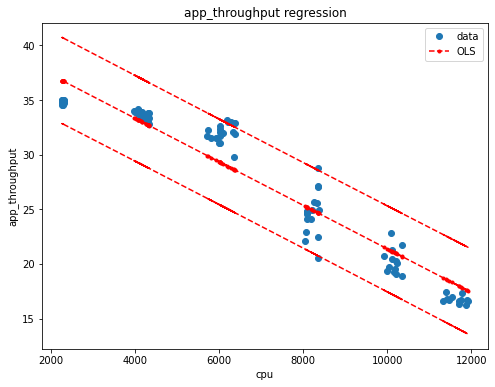

In [11]:
results = fit_regression(data=df2, formula='app_throughput ~ cpu')
draw_regression_graph(results, df2, metric_name='app_throughput', variable='cpu')
print(results.summary())